# A Transfer Learning Approach to Classifying the Intel Image Dataset

I will be applying transfer learning to solve the image classification task on the Intel Image Classification dataset. The dataset contains ~25,000 images of size 150x150 pixels, distributed under six categories:

`{‘building’: 0, ‘forest’: 1, ‘glacier’: 2, ‘mountain’: 3, ‘sea’: 4, ‘street’: 5}`

The Train, Test, and Prediction data is separated into the corresponding folders. There are around 14,000 images in Train, 3,000 images in Test, and 7,000 images in Prediction.

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
# For PyTorch/CUDA debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Part 1: Create Datasets and Dataloaders

In [2]:
# Create Datasets and Dataloaders for Train and Test
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize, Normalize, ColorJitter, RandomHorizontalFlip, RandomVerticalFlip, Compose
from torchvision.transforms.functional import to_pil_image

In [3]:

# Define the custom dataset class for the Intel Image Classification data
class IntelImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

        # class_names = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']
        # Iterate through the subdirectories and collect image paths and labels
        for label, idx in self.class_to_idx.items():
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for img_file in os.listdir(label_dir):
                    img_path = os.path.join(label_dir, img_file)
                    self.image_paths.append(img_path)
                    # self.labels.append(self.class_to_idx[label])  # added to fix label issues
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = read_image(img_path)  # Returns a tensor
        image = to_pil_image(image)  # Convert tensor to PIL Image for transformations

        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]  # Now an integer label
        return image, label

In [4]:
# Compose the transforms to be applied to the train images
train_transforms = Compose([
    Resize((224, 224)),  # Resize to 224x224 for compatibility with ResNet
    ToTensor(),  # may be unnecessary if using read_image
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    RandomHorizontalFlip(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Compose the transforms to be applied to the test images
# Note: No data augmentation for test images 
test_transforms = Compose([Resize((224, 224)), 
                           ToTensor(), 
                           Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [6]:
# Define the root directory for the dataset
ROOT_DIR = os.getcwd()
# Define the directories for training and testing datasets
TRAIN_DIR = os.path.join(ROOT_DIR, 'seg_train/seg_train')
TEST_DIR = os.path.join(ROOT_DIR, 'seg_test/seg_test')

In [7]:
# Check that the directory paths are correct
print("Train Directory:", TRAIN_DIR)
print("Test Directory:", TEST_DIR)

Train Directory: c:\Users\shak-\OneDrive\Desktop\myProjects\EN.705.643 PyTorch\assignment_2\seg_train/seg_train
Test Directory: c:\Users\shak-\OneDrive\Desktop\myProjects\EN.705.643 PyTorch\assignment_2\seg_test/seg_test


In [8]:
# Create the datasets
train_dataset = IntelImageDataset(root_dir=TRAIN_DIR, transform=train_transforms)
test_dataset = IntelImageDataset(root_dir=TEST_DIR, transform=test_transforms)

# Create "validation_dataset" from train_dataset by shuffling and splitting
train_size = int(0.8 * len(train_dataset)) # 80% for training
val_size = len(train_dataset) - train_size # 20% for validation
indices = list(range(len(train_dataset)))
np.random.shuffle(indices) # Shuffle the indices
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create subsets for training and validation
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

In [9]:
# Create the dataloaders (train, validation, and test)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
print("Number of training samples:", len(train_loader.dataset))
print("Number of validation samples:", len(val_loader.dataset))
print("Number of test samples:", len(test_loader.dataset))

Number of training samples: 11227
Number of validation samples: 2807
Number of test samples: 3000


In [11]:
# Print labels and their corresponding indices from the training dataset
labels = train_dataset.labels
unique_labels = set(labels)
label_indices = {label: [] for label in unique_labels}
for idx, label in enumerate(labels):
    label_indices[label].append(idx)
print("Image labels and their corresponding indices:")
for label, indices in label_indices.items():
    print(f"{label}: {indices[:5]}...")  # Print first 5 indices for each label

Image labels and their corresponding indices:
0: [0, 1, 2, 3, 4]...
1: [2191, 2192, 2193, 2194, 2195]...
2: [4462, 4463, 4464, 4465, 4466]...
3: [6866, 6867, 6868, 6869, 6870]...
4: [9378, 9379, 9380, 9381, 9382]...
5: [11652, 11653, 11654, 11655, 11656]...


In [12]:
# Print labels and indices of first batch from train_loader
def print_batch_labels(dataloader):
    for images, labels in dataloader:
        print("Batch labels:", labels)
        break  # Only print the first batch

print("Labels and indices of first batch from train_loader:")
print_batch_labels(train_loader)

Labels and indices of first batch from train_loader:


Batch labels: tensor([1, 5, 1, 5, 4, 3, 3, 0, 2, 4, 2, 3, 5, 4, 0, 2, 4, 1, 3, 1, 4, 1, 1, 0,
        4, 4, 0, 2, 1, 3, 5, 3])


### `display_images`

Visualize $n$ images from the specified dataloader, along with the corresponding category labels.

Inputs:
* dataloader : `train_loader`, `val_loader`, or `test_loader`
* num_images : the number of images to visualize

Outputs:
* Plot of images using Matplotlib

In [13]:
def display_images(dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

Visualizing a few images from the train_loader:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0140069..2.5328393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9847753..1.3625731].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9638605..2.0304232].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.544216..1.9143083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1165204..2.3204005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9259083..2.64].


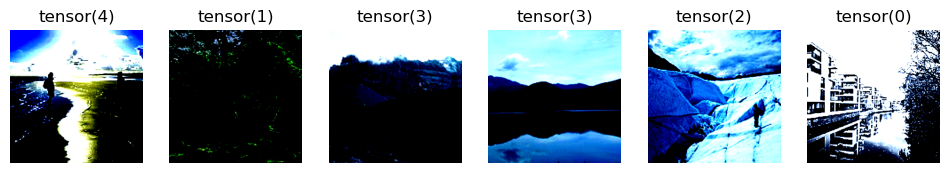

In [14]:
print("Visualizing a few images from the train_loader:")
display_images(train_loader, num_images=6)

Visualizing a few images from the val_loader:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4735175..2.401681].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0752382..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7420472..1.7813785].


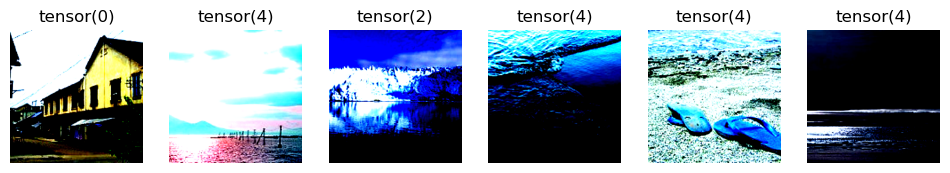

In [15]:
print("Visualizing a few images from the val_loader:")
display_images(val_loader, num_images=6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5179958].


Visualizing a few images from the test_loader:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..2.1632845].


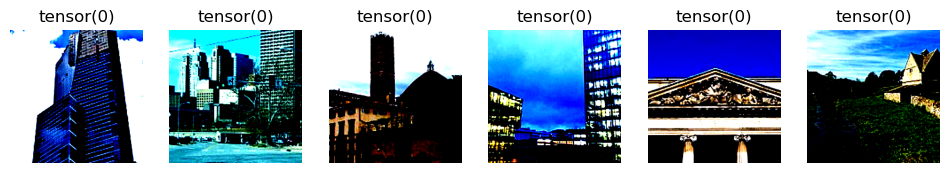

In [16]:
# Note: The test_loader is not shuffled, but we can still visualize images from it.
print("Visualizing a few images from the test_loader:")
display_images(test_loader, num_images=6)

## Part 2: Optimizer, Loss Function, and Train/Test Functions

In [17]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
from tqdm import tqdm
import time

I need to define and load a model here so I can get model parameters to pass to the optimizer. I chose ResNet-18, which is the model from [“Deep Residual Learning for Image Recognition”](https://arxiv.org/pdf/1512.03385). More details of this model are in the written report.

In [18]:
from torchvision.models import resnet18, ResNet18_Weights

# Load a pre-trained ResNet18 model
model = resnet18(weights='DEFAULT')

### Optimizer

I chose the Adam optimizer.

In [19]:
# Optimizer for only the fully connected layer
optimizer_fc = optim.Adam(model.fc.parameters(), lr=0.001)
# Optimizer for all layers
optimizer_all = optim.Adam(model.parameters(), lr=0.001)

### Loss Function

Since this is a classification task, I used the standard Cross-Entropy Loss function.

In [20]:
criterion = nn.CrossEntropyLoss()

### `train`

This is a helper function which encapsulates the forward and backpropagation steps while calculating the running loss and accuracy for one training epoch.

Inputs:
* model : neural network model to be trained
* dataloader: the training Dataloader
* criterion: the loss function to use for backpropagation
* optimizer: the optimizer to use for backpropagation

Output:
* epoch_loss: running loss
* epoch_accuracy: proportion of correct predictions

In [21]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = correct / total * 100.0
    return epoch_loss, epoch_accuracy

### `test`

Inputs: 
* model : neural network model to be trained
* dataloader: the training Dataloader
* criterion: the loss function to use for backpropagation

Outputs: 
* epoch_loss: running loss
* epoch_accuracy: proportion of correct predictions

In [22]:
def test(model, dataloader, criterion):
    model.eval()
    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = correct / total * 100.0
    return epoch_loss, epoch_accuracy

## Part 3: Perform Transfer Learning

Choose any CNN from the `torch classification list` that are pretrained on ImageNet and perform transfer learning on the Train/Test splits. Make sure that you implement two forms of transfer learning:

1. CNN as a fixed feature extractor
2. Finetuning the entire CNN
3. Report results of (1) and (2) on the Validation set. Compare and analyze the performance. Provide some comments to discuss the results.

In [23]:
# hyperparameters
num_epochs = 10
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3.1: Using ResNet-18 as Fixed Feature Extractor

In [24]:
# Freeze the feature extractor
for param in model.parameters():
    param.requires_grad = False

In [25]:
num_features = model.fc.in_features
# Replace the final fully connected layer
model.fc = nn.Linear(num_features, num_classes)
# Set device to GPU if available
model = model.to(device)
# Print the model architecture
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# Optimizer for only the fully connected layer
optimizer_fc = optim.Adam(model.fc.parameters(), lr=0.001)
# Optimizer for all layers
optimizer_all = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer_fc)
    #val_loss, val_accuracy = test(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    #print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10


100%|██████████| 351/351 [05:09<00:00,  1.13it/s]


Train Loss: 0.5672, Train Accuracy: 81.2862
Epoch 2/10


100%|██████████| 351/351 [02:18<00:00,  2.54it/s]


Train Loss: 0.3413, Train Accuracy: 88.2070
Epoch 3/10


100%|██████████| 351/351 [02:16<00:00,  2.58it/s]


Train Loss: 0.3224, Train Accuracy: 88.8839
Epoch 4/10


100%|██████████| 351/351 [02:16<00:00,  2.57it/s]


Train Loss: 0.3063, Train Accuracy: 88.8483
Epoch 5/10


100%|██████████| 351/351 [02:13<00:00,  2.62it/s]


Train Loss: 0.2917, Train Accuracy: 89.7212
Epoch 6/10


100%|██████████| 351/351 [02:14<00:00,  2.60it/s]


Train Loss: 0.2937, Train Accuracy: 89.0799
Epoch 7/10


100%|██████████| 351/351 [02:17<00:00,  2.55it/s]


Train Loss: 0.2803, Train Accuracy: 89.9795
Epoch 8/10


100%|██████████| 351/351 [02:13<00:00,  2.62it/s]


Train Loss: 0.2817, Train Accuracy: 89.6945
Epoch 9/10


100%|██████████| 351/351 [02:14<00:00,  2.62it/s]


Train Loss: 0.2807, Train Accuracy: 89.5342
Epoch 10/10


100%|██████████| 351/351 [02:12<00:00,  2.65it/s]

Train Loss: 0.2764, Train Accuracy: 89.7212


In [27]:
# Save the model
torch.save(model.state_dict(), 'model_fixed_features.pth')

### 3.2: Fine-tuning Entire ResNet-18 Model

In [28]:
# Load ResNet-18 model with default weights
model = resnet18(weights='DEFAULT')

# Un-freeze the feature extractor
for param in model.parameters():
    param.requires_grad = True

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# Set device to GPU if available
model = model.to(device)

# Re-initialize the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Print the model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Model Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer_all)
    val_loss, val_accuracy = test(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10


100%|██████████| 88/88 [01:19<00:00,  1.11it/s]


Train Loss: 2.0591, Train Accuracy: 16.3178
Validation Loss: 2.0615, Validation Accuracy: 17.5989
Epoch 2/10


100%|██████████| 88/88 [37:40<00:00, 25.69s/it]    


Train Loss: 2.0554, Train Accuracy: 15.8279
Validation Loss: 2.0643, Validation Accuracy: 17.5989
Epoch 3/10


100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


Train Loss: 2.0589, Train Accuracy: 16.1842
Validation Loss: 2.0523, Validation Accuracy: 17.0289
Epoch 4/10


100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Train Loss: 2.0552, Train Accuracy: 16.1575
Validation Loss: 2.0608, Validation Accuracy: 17.6701
Epoch 5/10


100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


Train Loss: 2.0571, Train Accuracy: 16.3623
Validation Loss: 2.0628, Validation Accuracy: 17.0645
Epoch 6/10


100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Train Loss: 2.0555, Train Accuracy: 16.2376
Validation Loss: 2.0717, Validation Accuracy: 17.4207
Epoch 7/10


100%|██████████| 88/88 [00:28<00:00,  3.04it/s]


Train Loss: 2.0545, Train Accuracy: 16.3712
Validation Loss: 2.0583, Validation Accuracy: 17.4564
Epoch 8/10


100%|██████████| 88/88 [00:28<00:00,  3.06it/s]


Train Loss: 2.0566, Train Accuracy: 16.3980
Validation Loss: 2.0616, Validation Accuracy: 16.9932
Epoch 9/10


100%|██████████| 88/88 [00:28<00:00,  3.09it/s]


Train Loss: 2.0549, Train Accuracy: 16.1218
Validation Loss: 2.0581, Validation Accuracy: 16.6014
Epoch 10/10


100%|██████████| 88/88 [00:27<00:00,  3.16it/s]

Train Loss: 2.0571, Train Accuracy: 16.1664
Validation Loss: 2.0622, Validation Accuracy: 17.0289


In [30]:
# Save the model
torch.save(model.state_dict(), 'model_finetune_all.pth')

### Results

Comparing the results of both transfer learning methods, both had validation accuracy not greater than 20%. Since there are six output classes, a naive classifier would yield an accuracy of 16.67%. Thus, both methods had low accuracy after training. However, this is most likely due to the low number of training epochs (only 10 epochs). I only trained for 10 epochs since I, regrettably, spent the majority of my time debugging code and CUDA errors.

The fixed feature extraction method, where only the last layer is fine-tuned, is typically enough to get good performance for small datasets. Fine-tuning the full model is more appropriate when using a very large, complex dataset. Since the Intel Image dataset is very large, I would expect that the method of fine-tuning the entire ResNet-18 model would yield better results.

### Resubmission Updates

* removed Vertical Flips from data augmentations applied to the train dataset
* update custom Dataset class parameter `self.class_to_idx` to have the correct class labels: 'building' --> 'buildings'
* update `display_images` function description
* update `train` helper function description
* update `test` helper function description
* In Section 3.2, change optimizer from `optimizer_fc` to `optimizer_all`
* Remove all data augmentations from the list of transformations applied to the test dataset. Resize and normalization only.
* Rerun training/validation loops using train/val datasets, now with the correct class labels

--- 

The results of the fixed feature extractor method were ~90% training accuracy. This was much better than the results of training the entire model (without pre-trained weights). The difference in accuracy highlights the clear advantage of using the pre-trained weights for a model and then fine-tuning it for our specific use case (transfer learning).